# <b> Pattern Recognition <b>
## <b> Speech Emotion Recognition Assignment <b>

---

## Data Preprocessing

In [1]:
import os
from glob import glob
import kagglehub
import librosa
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import tensorflow as tf
from IPython.display import Markdown
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
    Flatten, Dense, Input, Dropout, AveragePooling2D, BatchNormalization,
    GlobalAveragePooling2D, GlobalMaxPooling2D)

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

---

### Dataset Loading

In [2]:
def plot_audio(audio, sr):
    """
    Plot waveform and play audio
    """
    ipd.display(ipd.Audio(audio, rate=sr))
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

In [3]:
def plot_spectrogram(mel_spect_db, sr):
    """
    Plot spectrogram
    """
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spect_db, sr=sr, x_axis="time", y_axis="mel", fmax=8000)
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Spectrogram")
    plt.show()

In [4]:
def load_dataset():
    path = kagglehub.dataset_download("dmitrybabko/speech-emotion-recognition-en")+"/Crema"
    if not os.path.isdir(path):
        raise FileNotFoundError("Download CREMA dataset.")

    X_time = []
    X_freq = []
    y = []
    sample_audios = {}

    try:
        X_time = np.load('data.npz')['time']
        X_freq = np.load('data.npz')['freq']
        y = np.load('data.npz')['labels']
        print("Extracted Dataset is already stored")
    except FileNotFoundError:
        print("Extract Dataset for the first time and saving.")
        audio_files = sorted(glob(f"{path}/*.wav"))
        print(f'Audio Files Number: {len(audio_files)}')

        for audio_file in audio_files:
            audio, sr = librosa.load(audio_file)
            audio_fixed = librosa.util.fix_length(audio, size=int(5 * sr))

            zcr = librosa.feature.zero_crossing_rate(audio_fixed, frame_length=2048, hop_length=512)
            energy = librosa.feature.rms(y=audio_fixed, frame_length=2048, hop_length=512)
            mel_spec = librosa.feature.melspectrogram(y=audio_fixed, sr=sr)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            X_time.append(np.vstack((zcr, energy)))
            X_freq.append(mel_spec_db)
            label = audio_file.split("_")[2]
            y.append(label)

            # Plot audio randomly
            if label not in sample_audios or len(sample_audios[label]) < 2:
                sample_audios[label] = sample_audios.get(label, []) + [(audio, sr)]


        np.savez('data.npz', time=X_time, freq=X_freq, labels=y)
        for label in sample_audios:
          display(Markdown(f"<center><b>{'━'*100}</b></center>"))
          text = Markdown(f'## <center>Label: {label}</center>')
          display(text)
          display(Markdown(f"<center><b>{'━'*100}</b></center>"))
          for audio, sr in sample_audios[label]:
              display(Markdown(f"### <center>Audio: {audio}</center>"))
              plot_audio(audio, sr)
              mel_spec_before_padding = librosa.feature.melspectrogram(y=audio, sr=sr)
              mel_spec_db = librosa.power_to_db(mel_spec_before_padding, ref=np.max)
              plot_spectrogram(mel_spec_db, sr)

    return X_time, X_freq, y

---

### Data Separation

In [5]:
def separate_dataset():
    # Time Domain Split
    X_time, X_freq, y = load_dataset()
    X_time_train_val, X_time_test, y_time_train_val, y_time_test = train_test_split(X_time, y, train_size=0.7, stratify=y, random_state=SEED)
    X_time_train, X_time_val, y_time_train, y_time_val = train_test_split(X_time_train_val, y_time_train_val, train_size=0.95, stratify=y_time_train_val, random_state=SEED)
    # Frequency Domain Split
    X_freq_train_val, X_freq_test, y_freq_train_val, y_freq_test = train_test_split(X_freq, y, train_size=0.7, stratify=y, random_state=SEED)
    X_freq_train, X_freq_val, y_freq_train, y_freq_val = train_test_split(X_freq_train_val, y_freq_train_val, train_size=0.95, stratify=y_freq_train_val, random_state=SEED)

    # Convert to NumPy arrays
    X_time_train = np.array(X_time_train)
    y_time_train = np.array(y_time_train)
    X_freq_train = np.array(X_freq_train)
    y_freq_train = np.array(y_freq_train)

    X_time_val = np.array(X_time_val)
    y_time_val = np.array(y_time_val)
    X_freq_val = np.array(X_freq_val)
    y_freq_val = np.array(y_freq_val)

    X_time_test = np.array(X_time_test)
    y_time_test = np.array(y_time_test)
    X_freq_test = np.array(X_freq_test)
    y_freq_test = np.array(y_freq_test)

    print(f'Training Set: time domain shape {X_time_train.shape}, frequency domain shape {X_freq_train.shape}')
    print(f'Validation Set: time domain shape {X_time_val.shape}, frequency domain shape {X_freq_val.shape}')
    print(f'Test Set: time domain shape {X_time_test.shape}, frequency domain shape {X_freq_test.shape}')

    return (X_time_train, X_freq_train, X_time_val, X_freq_val, X_time_test, X_freq_test,
    y_time_train, y_freq_train, y_time_val, y_freq_val, y_time_test, y_freq_test)

---

Extract Dataset for the first time and saving.
Audio Files Number: 7442


<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

## <center>Label: ANG</center>

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

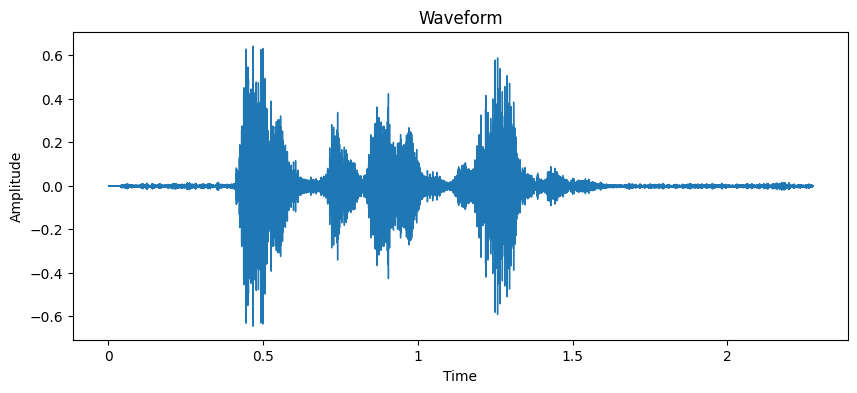

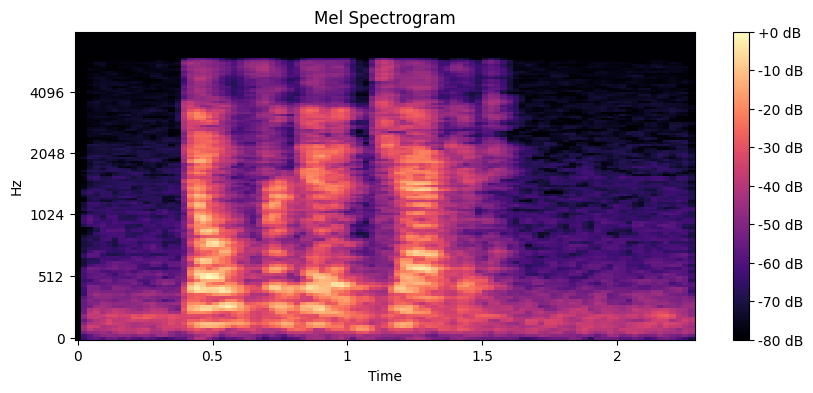

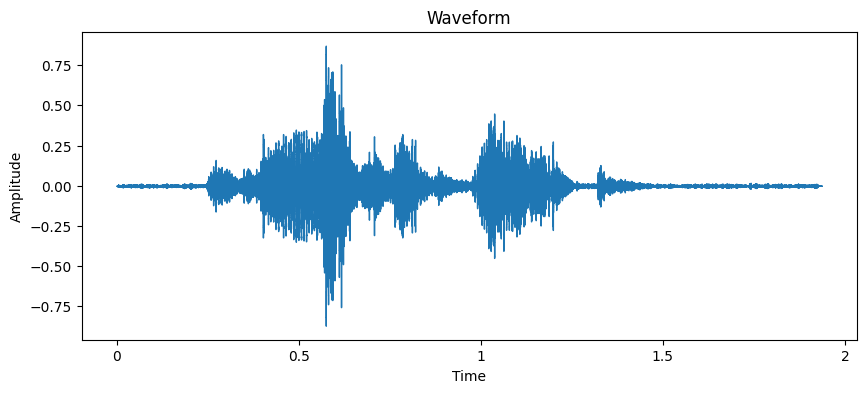

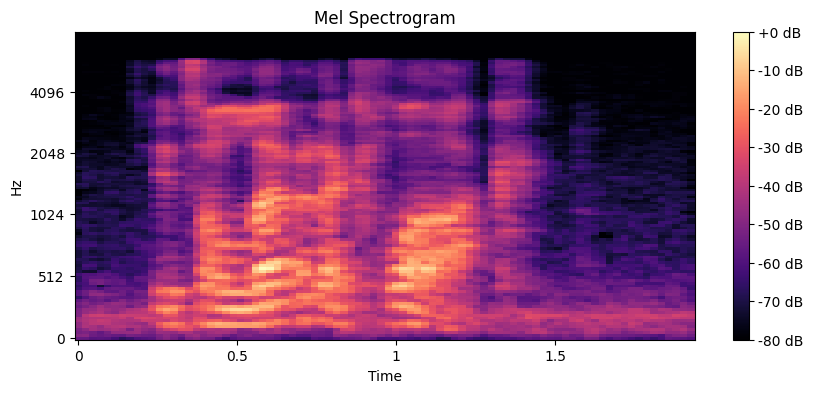

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

## <center>Label: DIS</center>

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

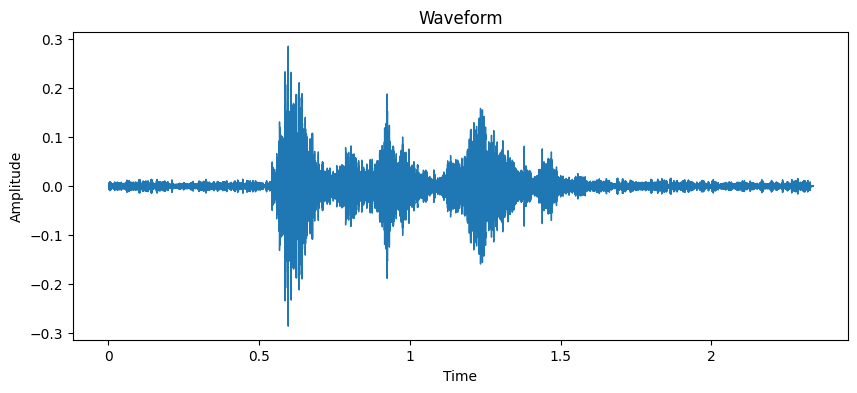

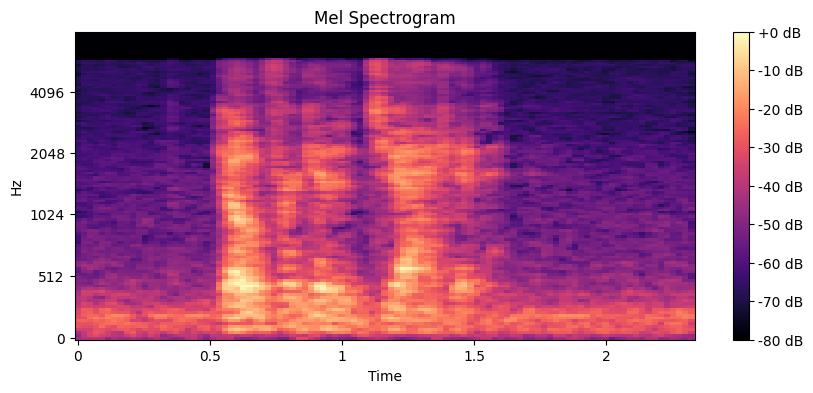

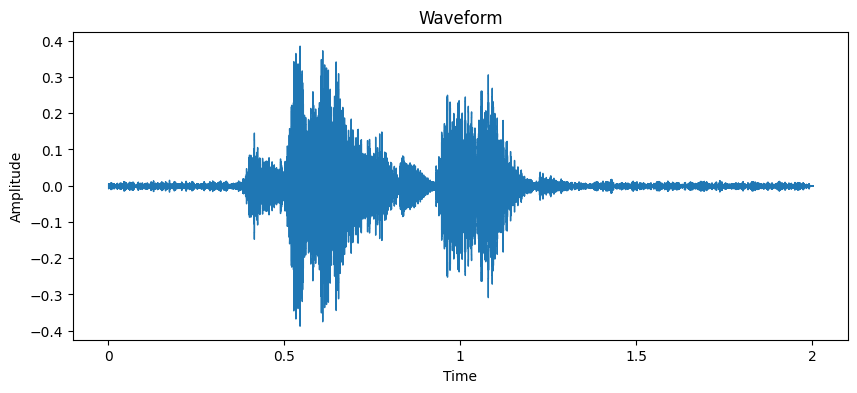

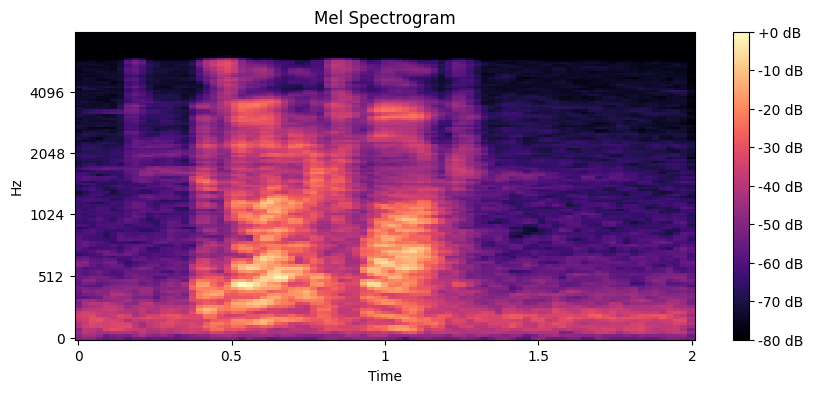

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

## <center>Label: FEA</center>

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

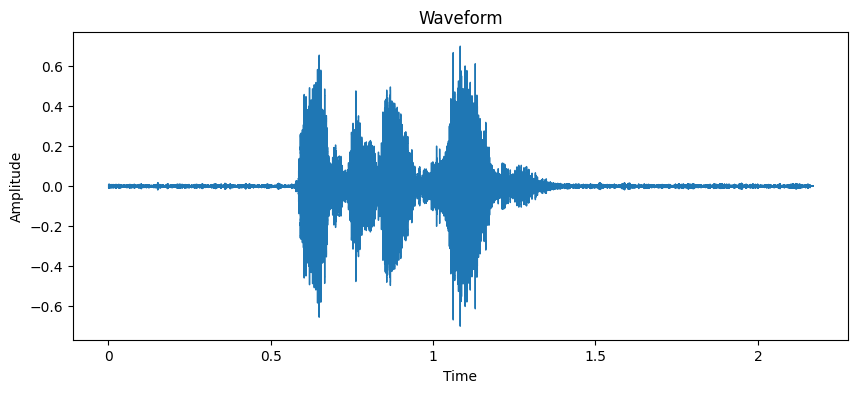

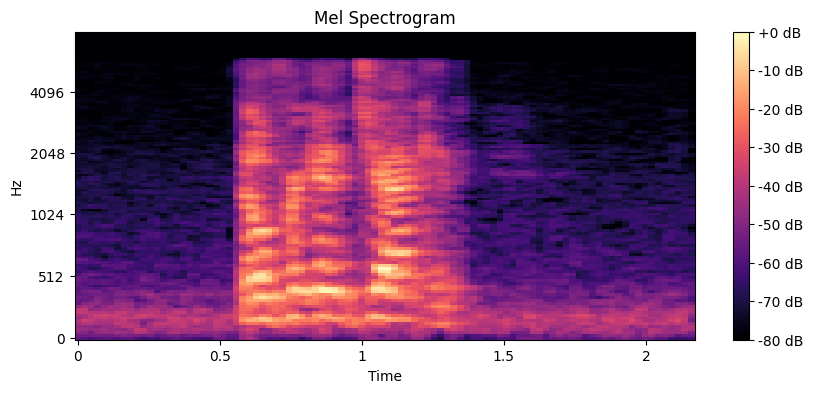

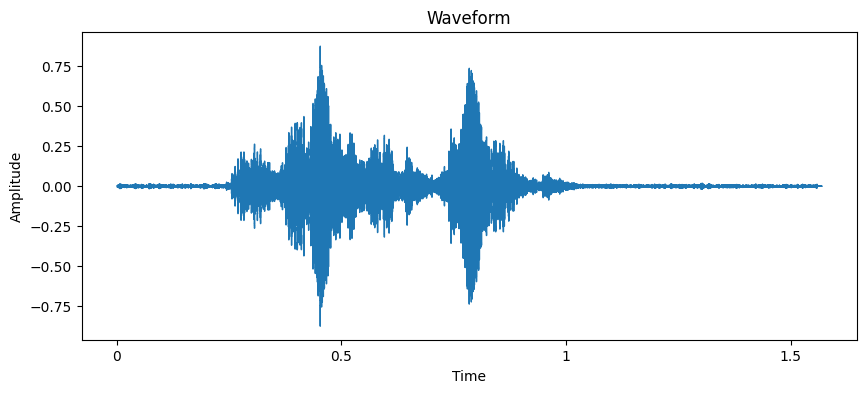

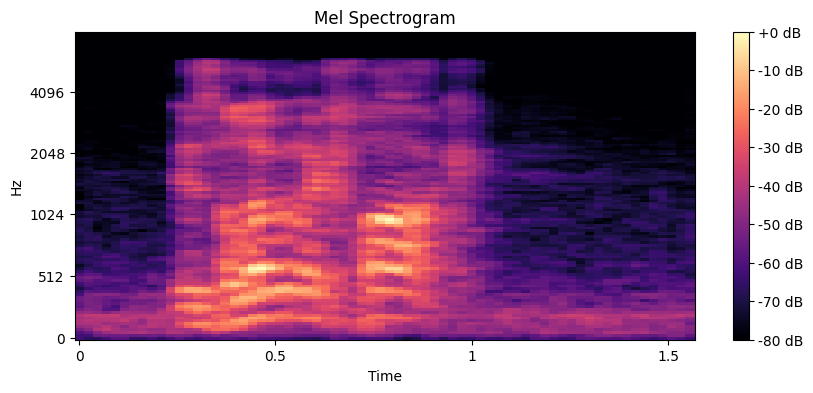

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

## <center>Label: HAP</center>

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

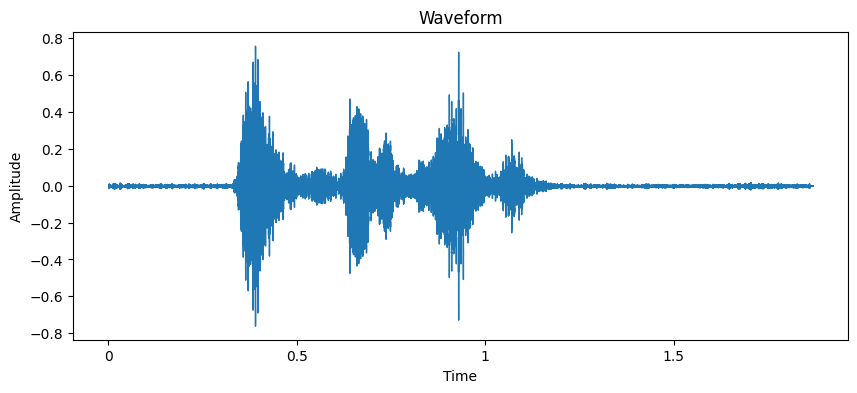

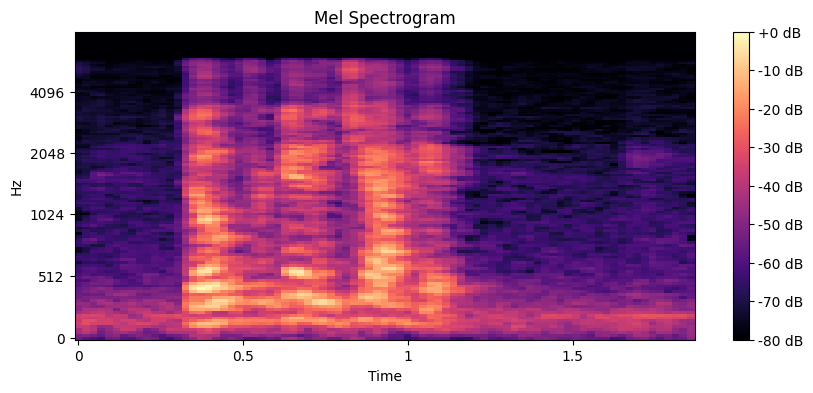

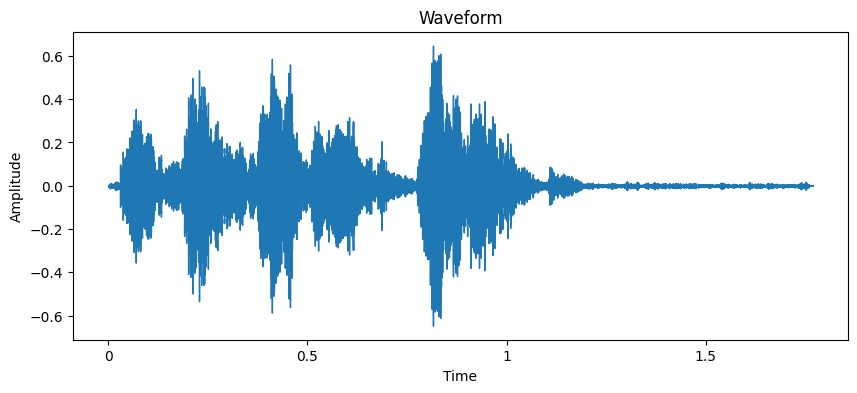

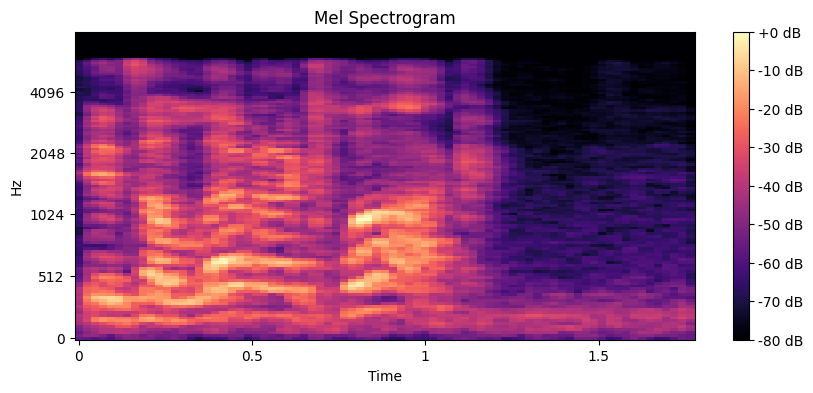

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

## <center>Label: NEU</center>

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

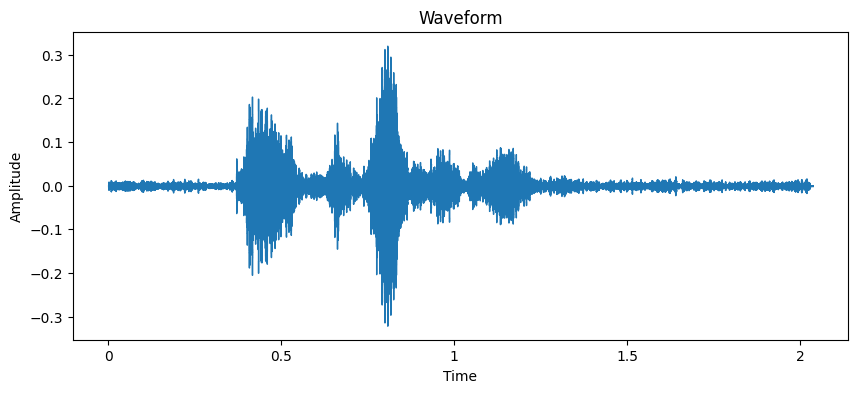

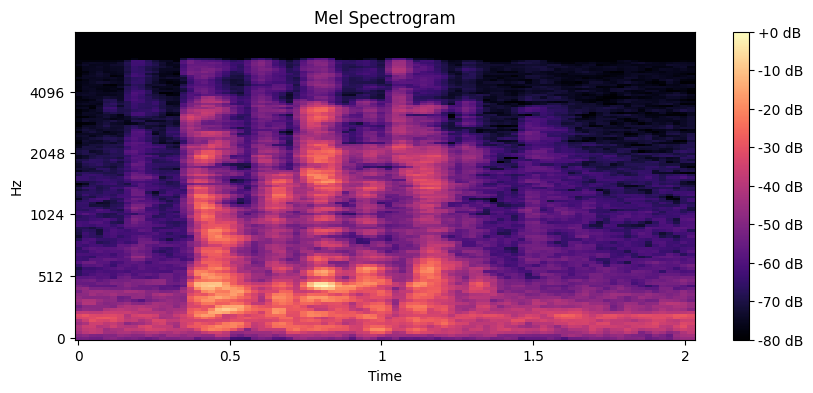

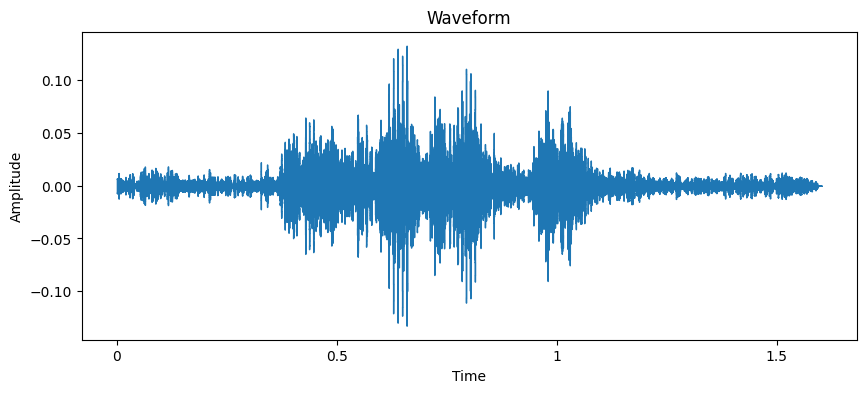

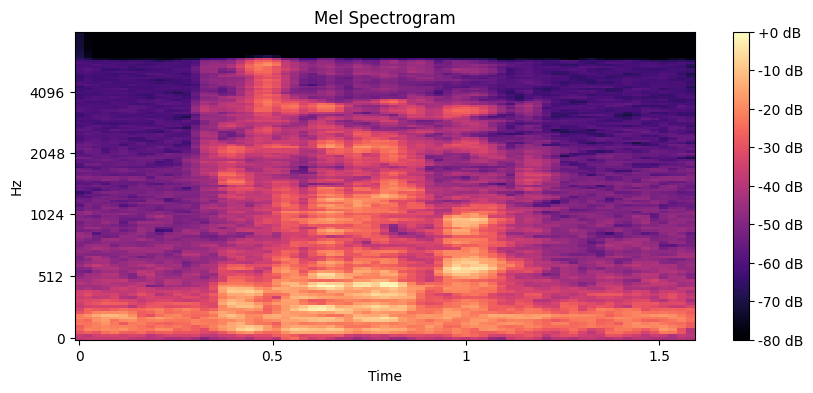

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

## <center>Label: SAD</center>

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

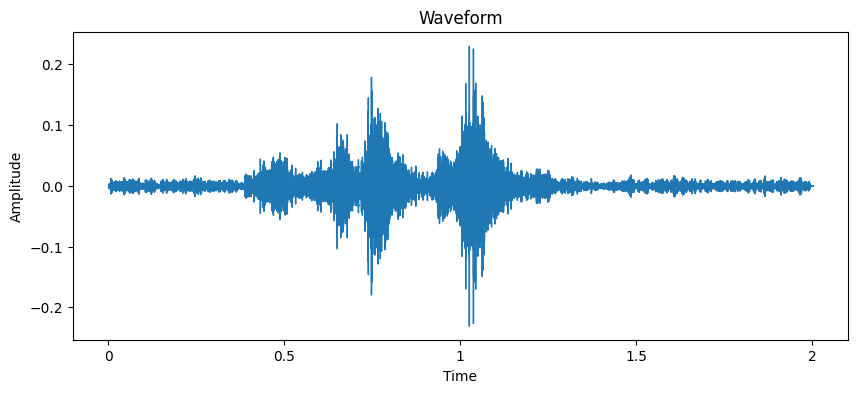

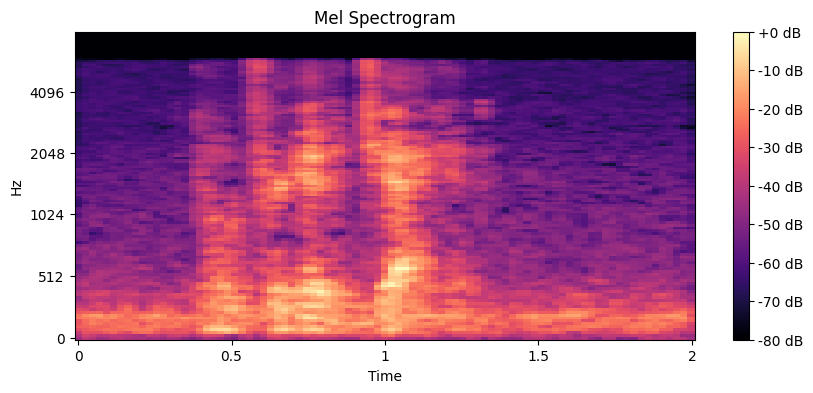

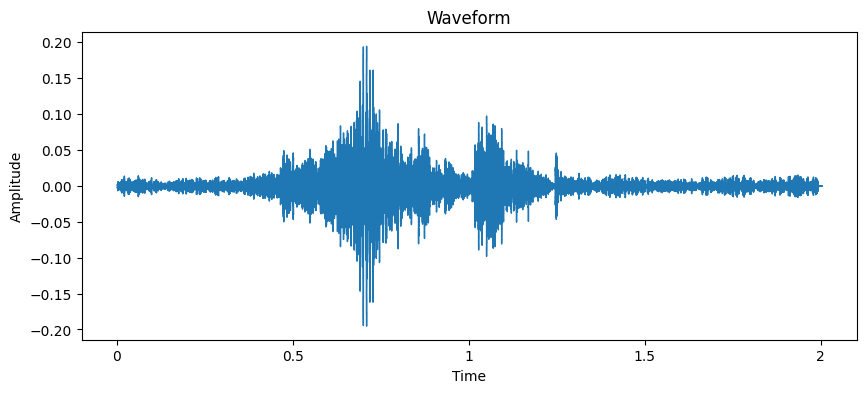

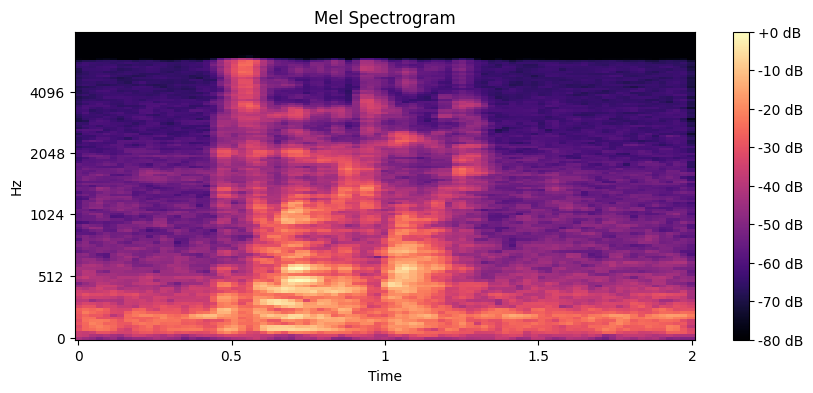

Training Set: time domain shape (4948, 2, 216), frequency domain shape (4948, 128, 216)
Validation Set: time domain shape (261, 2, 216), frequency domain shape (261, 128, 216)
Test Set: time domain shape (2233, 2, 216), frequency domain shape (2233, 128, 216)


In [6]:
(X_time_train, X_freq_train, X_time_val, X_freq_val, X_time_test, X_freq_test,
 y_time_train, y_freq_train, y_time_val, y_freq_val, y_time_test, y_freq_test) = separate_dataset()

---

### Labels Encoding

In [7]:
# Convert to integers
encoder = LabelEncoder()
y_dup = y_freq_train.copy()
yhat_freq_train = encoder.fit_transform(y_dup)
yhat_freq_val = encoder.fit_transform(y_freq_val)

y_dup = y_freq_test.copy()
yhat_freq_test = encoder.fit_transform(y_dup)

labels = encoder.inverse_transform(range(6))
print(f"Label index: {np.arange(6)}")
print(f"Labels: {labels}")

Label index: [0 1 2 3 4 5]
Labels: ['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [8]:
tf.keras.backend.clear_session()

extended_X_train = (np.expand_dims(X_freq_train, axis=-1))
extended_X_val = np.expand_dims(X_freq_val, axis=-1)

# Add channel dimension (if not done earlier)
X_freq_train = np.expand_dims(X_freq_train, axis=-1)  # Shape: (4043, 128, 216, 1)
X_freq_test = np.expand_dims(X_freq_test, axis=-1)

---

## RNN Model

### 2D CNN

#### Tuning Hyperparameters

In [10]:
kernel_sizes = [(3, 3), (5, 5), (7, 7)]
filters = [32, 64, 128]
epochs = 50
results = []
histories = []
hyperparameters = []

for kernel_size in kernel_sizes:
    for filter in filters:
        print(f"Kernel Size: {kernel_size}, Filters: {filter}, Stride: {2}")

        model = Sequential([
            Input(shape=(128, 216, 1)),
            Conv2D(filter, kernel_size, activation='relu', padding='same'),
            MaxPooling2D((2, 2), strides=2),
            Conv2D(filter*2, kernel_size, activation='relu', padding='same'),
            MaxPooling2D((2, 2), strides=2),
            Conv2D(filter*2, kernel_size, activation='relu', padding='same'),
            GlobalAveragePooling2D(),
            Dense(64, activation='relu'),
            Dense(6, activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        history = model.fit(
            extended_X_train,
            yhat_freq_train,
            epochs=epochs,
            batch_size=64,
            validation_data=(extended_X_val, yhat_freq_val),
            callbacks=[early_stopping],
            verbose=0
        )

        val_loss = history.history['val_loss'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        training_loss = history.history['loss'][-1]
        training_accuracy = history.history['accuracy'][-1]

        print(f"- Validation Loss: {val_loss}")
        print(f"- Validation Accuracy: {val_accuracy}")
        print(f"- Training Loss: {training_loss}")
        print(f"- Training Accuracy: {training_accuracy}")
        print("---------------------------------------------")

        results.append(val_accuracy)
        histories.append(history)
        hyperparameters.append((kernel_size, filter))

Kernel Size: (3, 3), Filters: 32, Stride: 2
Validation Loss: 1.3798800706863403
Validation Accuracy: 0.4636015295982361
Training Loss: 1.36876380443573
Training Accuracy: 0.4367421269416809
---------------------------------------------
Kernel Size: (3, 3), Filters: 64, Stride: 2
Validation Loss: 1.2846062183380127
Validation Accuracy: 0.4482758641242981
Training Loss: 1.2970187664031982
Training Accuracy: 0.48241713643074036
---------------------------------------------
Kernel Size: (3, 3), Filters: 128, Stride: 2
Validation Loss: 1.260593056678772
Validation Accuracy: 0.49808427691459656
Training Loss: 1.2468042373657227
Training Accuracy: 0.5072756409645081
---------------------------------------------
Kernel Size: (5, 5), Filters: 32, Stride: 2
Validation Loss: 1.257440447807312
Validation Accuracy: 0.48659002780914307
Training Loss: 1.2500640153884888
Training Accuracy: 0.5056588649749756
---------------------------------------------
Kernel Size: (5, 5), Filters: 64, Stride: 2
Vali

Best Model: kernel size=(5, 5), filters=128
Best Accuracy: 0.5593869686126709


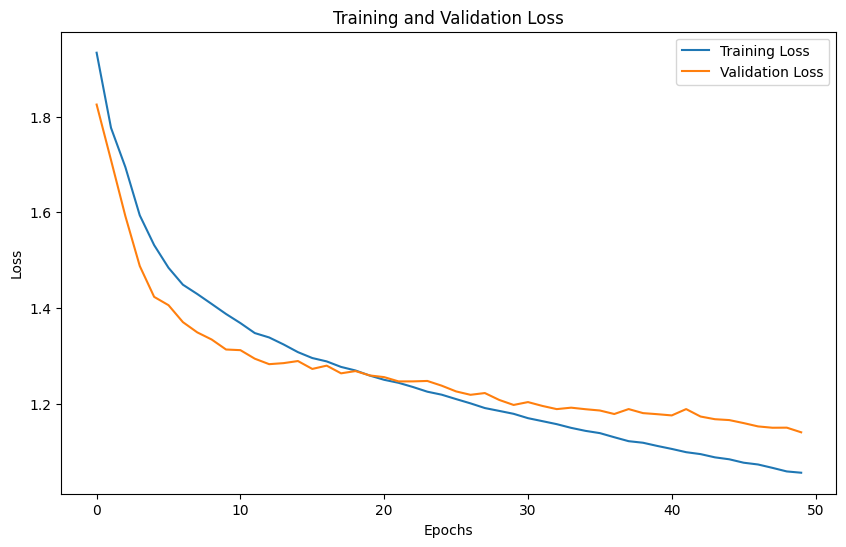

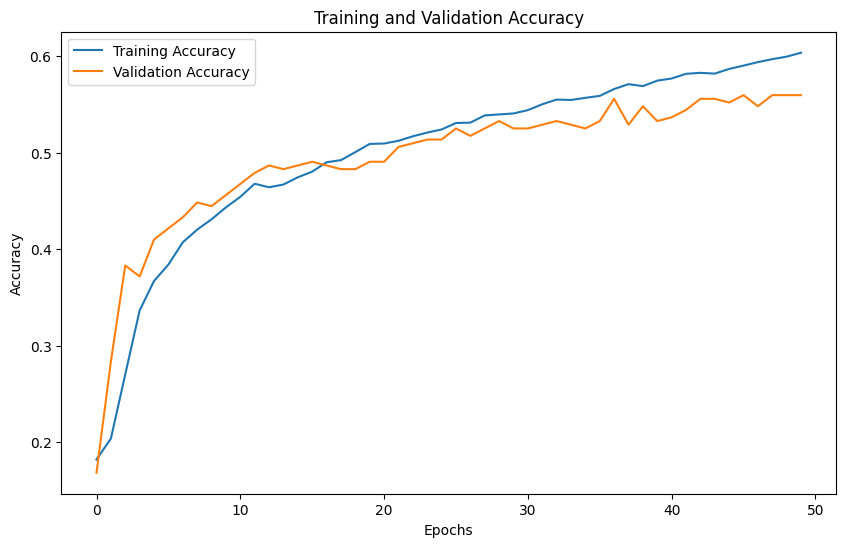

In [11]:
best_model_indx = np.argmax(results)
best_hyperparameters = hyperparameters[best_model_indx]
best_kernel_size, best_filter = best_hyperparameters

print(f"Best Model: kernel size={best_kernel_size}, filters={best_filter}")
print(f"Best Accuracy: {results[best_model_indx]}")

plt.figure(figsize=(10, 6))
plt.plot(histories[best_model_indx].history['loss'], label='Training Loss')
plt.plot(histories[best_model_indx].history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(histories[best_model_indx].history['accuracy'], label='Training Accuracy')
plt.plot(histories[best_model_indx].history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

#### Evaluate model on test set

In [12]:
best_model = Sequential([
    Input(shape=(128, 216, 1)),
    Conv2D(best_filter, best_kernel_size, activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(2*best_filter, best_kernel_size, activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(2*best_filter, best_kernel_size, activation='relu', padding='same'),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = best_model.fit(
    extended_X_train,
    yhat_freq_train,
    epochs=epochs,
    batch_size=64,
    validation_data=(extended_X_val, yhat_freq_val),
    callbacks=[early_stopping]
)

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.1599 - loss: 2.4150 - val_accuracy: 0.1686 - val_loss: 1.8311
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 38s 270ms/step - accuracy: 0.1878 - loss: 1.8095 - val_accuracy: 0.2069 - val_loss: 1.7836
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 276ms/step - accuracy: 0.2467 - loss: 1.7579 - val_accuracy: 0.3142 - val_loss: 1.6551
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 270ms/step - accuracy: 0.3263 - loss: 1.6291 - val_accuracy: 0.3410 - val_loss: 1.5656
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 42s 278ms/step - accuracy: 0.3530 - loss: 1.5641 - val_accuracy: 0.4176 - val_loss: 1.4895
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 272ms/step - accuracy: 0.3820 - loss: 1.5031 - val_accuracy: 0.4061 - val_loss: 1.4544
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 281ms/step - accuracy: 0.4036 - loss: 1.4641 - val_accuracy: 0.4291 - val_loss: 1.4135
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 268ms/step - accuracy: 0.4232 - loss: 1.4338 - val_accu

70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step
Test Accuracy: 0.5723 (57.23%)


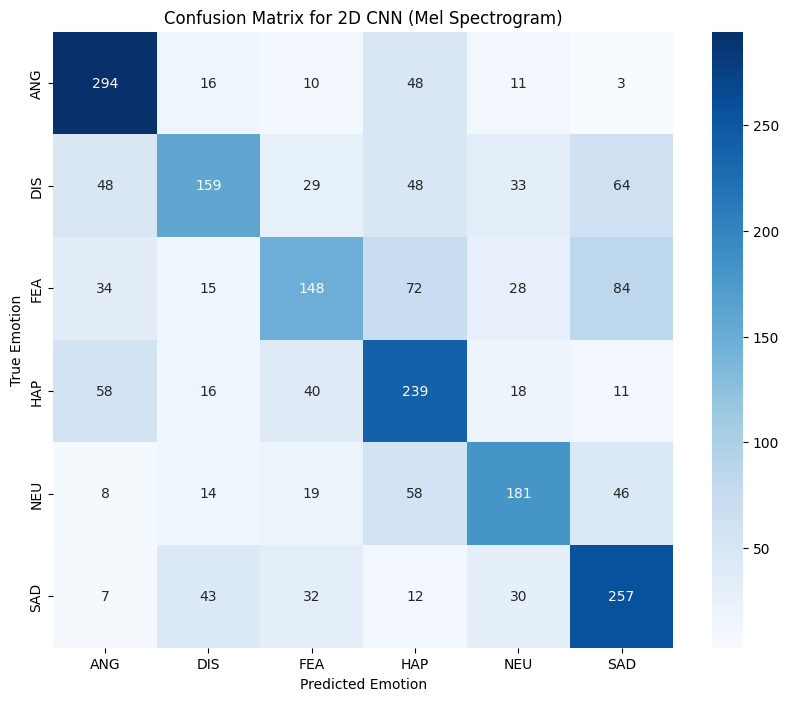


Classification Report:
              precision    recall  f1-score   support

         ANG       0.65      0.77      0.71       382
         DIS       0.60      0.42      0.49       381
         FEA       0.53      0.39      0.45       381
         HAP       0.50      0.63      0.56       382
         NEU       0.60      0.56      0.58       326
         SAD       0.55      0.67      0.61       381

    accuracy                           0.57      2233
   macro avg       0.57      0.57      0.57      2233
weighted avg       0.57      0.57      0.57      2233

Most confusing pair: True FEA predicted as SAD (normalized error: 0.2205)


In [13]:
y_pred = best_model.predict(X_freq_test)
y_pred = np.argmax(y_pred, axis=1)

test_accuracy = accuracy_score(yhat_freq_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")

cm = confusion_matrix(yhat_freq_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for 2D CNN (Mel Spectrogram)")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.show()

# Analyze confusion matrix
print("\nClassification Report:")
print(classification_report(yhat_freq_test, y_pred, target_names=labels))

# Identify most confusing classes
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize by true class
np.fill_diagonal(cm_norm, 0)  # Set diagonal to 0 to focus on errors
max_confusion = np.unravel_index(np.argmax(cm_norm, axis=None), cm_norm.shape)
true_class, pred_class = max_confusion
print(f"Most confusing pair: True {labels[true_class]} predicted as {labels[pred_class]} "
      f"(normalized error: {cm_norm[max_confusion]:.4f})")


In [14]:
best_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 128, 216, 128)  │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 64, 108, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 64, 108, 256)   │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 32, 54, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 32, 54, 256)    │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,434,836 (28.36 MB)

 Trainable params: 2,478,278 (9.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,956,558 (18.91 MB)

---